In [ ]:
##############################################################
# This notebook is for training a CNN for Accident detection #
# Framework is tensorflow                                    #
# This is MY usual solution that works in Most situations    #
# with reasonable Accuracy                                   #
# Thanks                                                     #
##############################################################

In [27]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
  

In [3]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [5]:
## loading training set
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 791 files belonging to 2 classes.


In [6]:
## loading validation dataset
validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)


Found 98 files belonging to 2 classes.


In [7]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)



Found 100 files belonging to 2 classes.


In [19]:
# Defining Cnn

MyCnn = tf.keras.models.Sequential([
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation= 'softmax')
    ])

MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
import mlflow
from mlflow import pyfunc
import mlflow.keras

# mlflow.set_tracking_uri("/images_usecase/mlruns")

experiment_name = 'Accidents-Classification'
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/images_usecase/mlruns/1', experiment_id='1', lifecycle_stage='active', name='Accidents-Classification', tags={}>

In [29]:
# retVal = MyCnn.fit(training_ds, validation_data= validation_ds, epochs = 1)

mlflow.keras.autolog()

with mlflow.start_run(run_name="Cnn_model"):
    ## lets train our CNN
    MyCnn.fit(training_ds, validation_data=validation_ds, epochs=10)

c:\Users\yahya_abbas\Miniconda3\envs\ml_env\lib\site-packages\mlflow\utils\autologging_utils\__init__.py:416: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)


Epoch 1/2
8/8 [==============================] - 159s 20s/step - loss: 0.3293 - accuracy: 0.8647 - val_loss: 0.8826 - val_accuracy: 0.5714
Epoch 2/2
8/8 [==============================] - 207s 25s/step - loss: 0.2166 - accuracy: 0.9140 - val_loss: 0.6159 - val_accuracy: 0.7551


INFO:tensorflow:Assets written to: C:\Users\YAHYA_~1\AppData\Local\Temp\tmp5s3lbkui\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\YAHYA_~1\AppData\Local\Temp\tmp5s3lbkui\model\data\model\assets


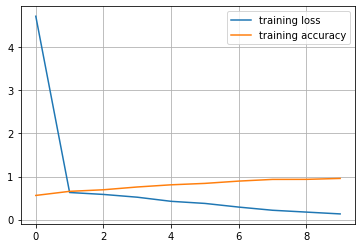

In [31]:
## stats on training data
# plt.plot(retVal.history['loss'], label = 'training loss')
# plt.plot(retVal.history['accuracy'], label = 'training accuracy')
# plt.grid(True)
# plt.legend()

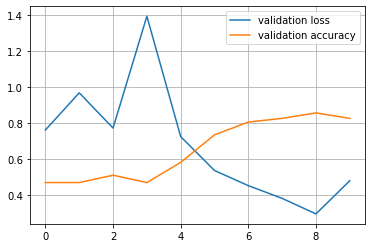

In [32]:
## stats on validation data
# plt.plot(retVal.history['val_loss'], label = 'validation loss')
# plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
# plt.grid(True)
# plt.legend()

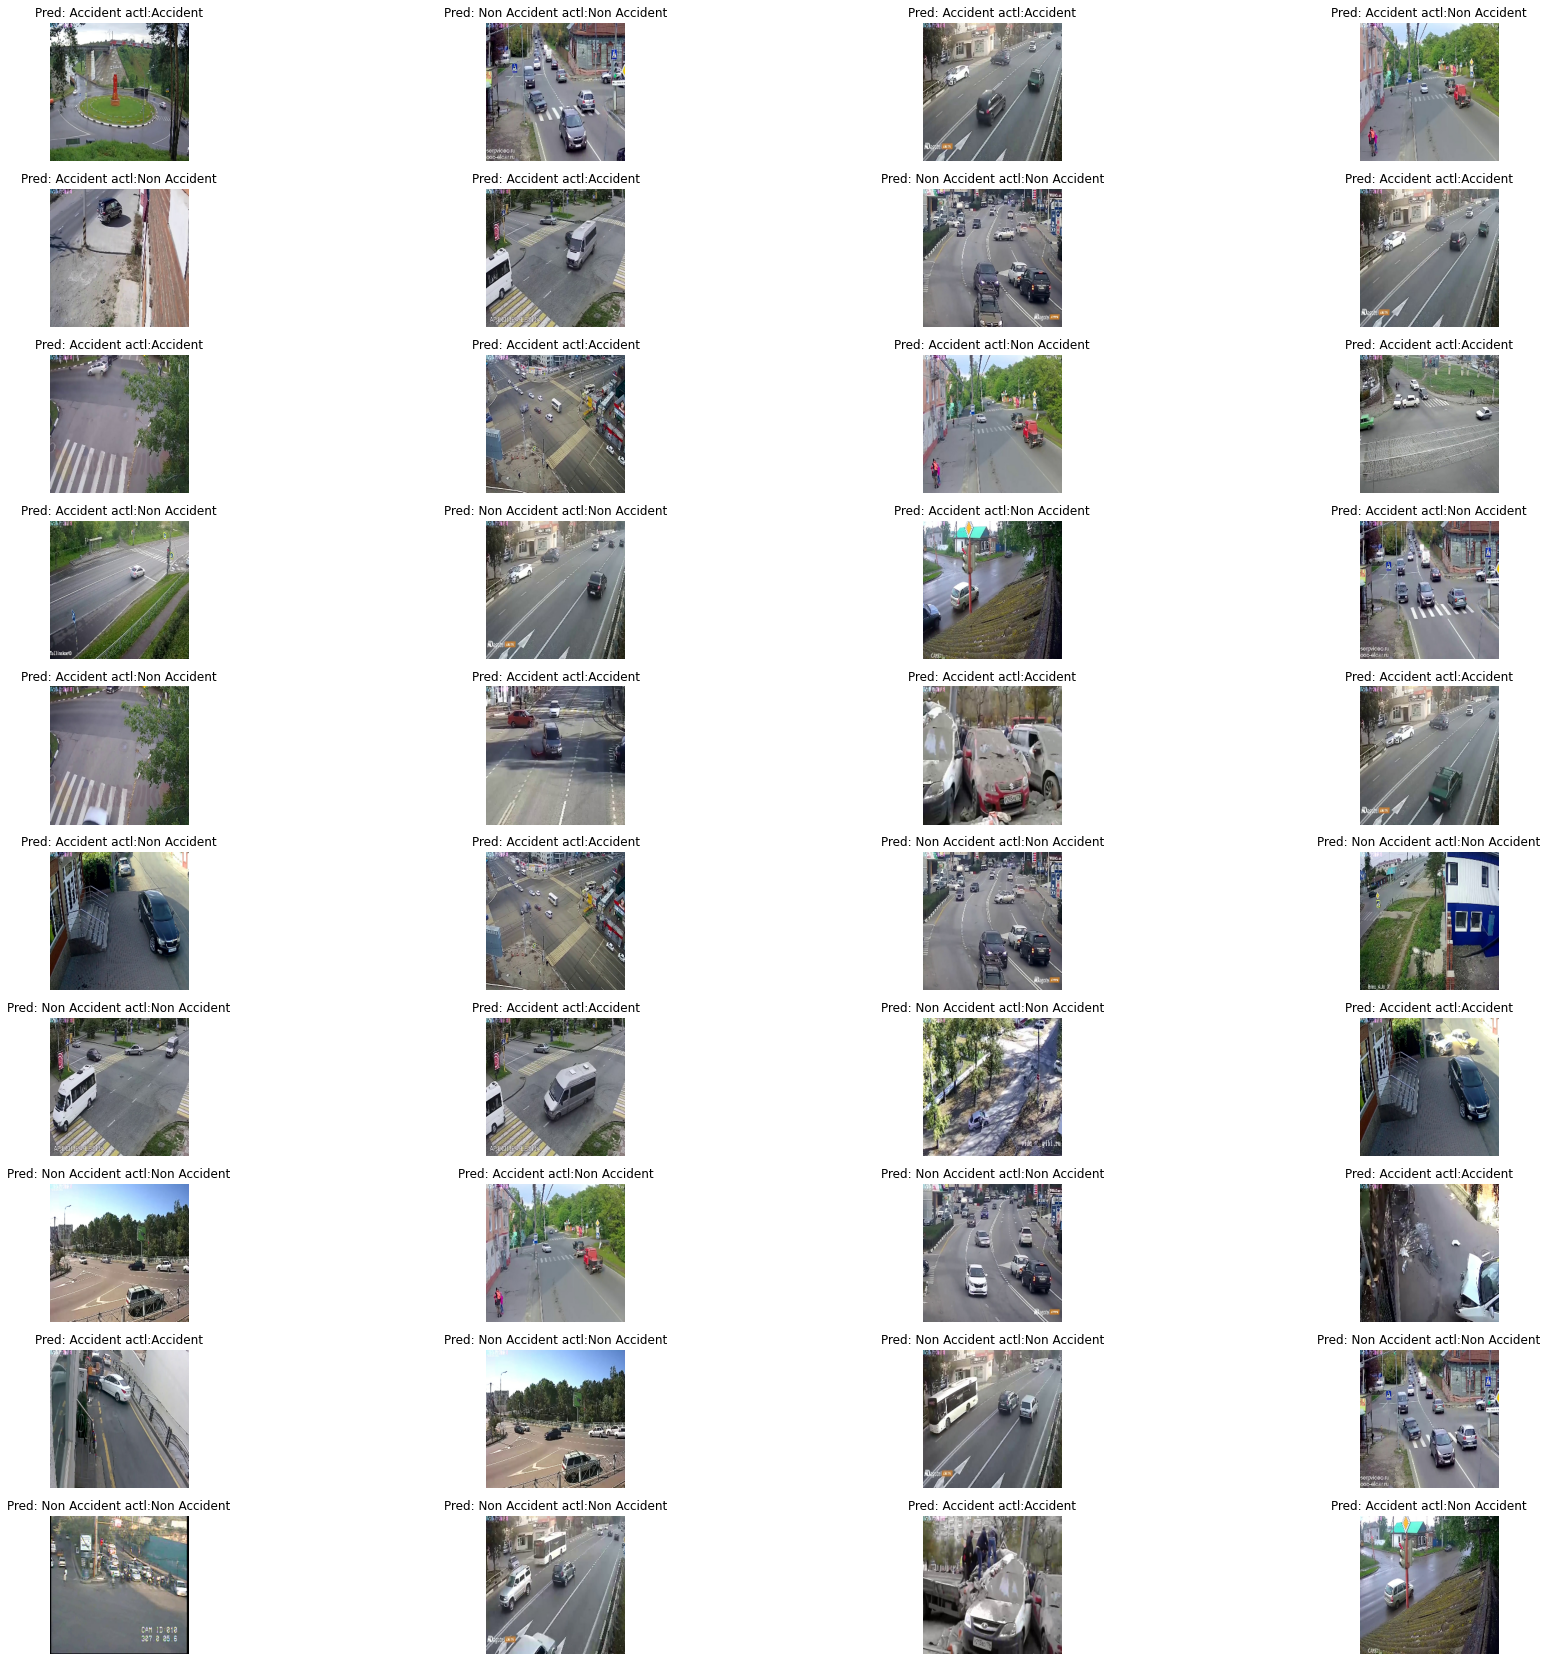

In [33]:
## lets vizualize results on testing data
AccuracyVector = []
pyfunc_model = pyfunc.load_model(mlflow.get_artifact_uri("model"))

plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = pyfunc_model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)